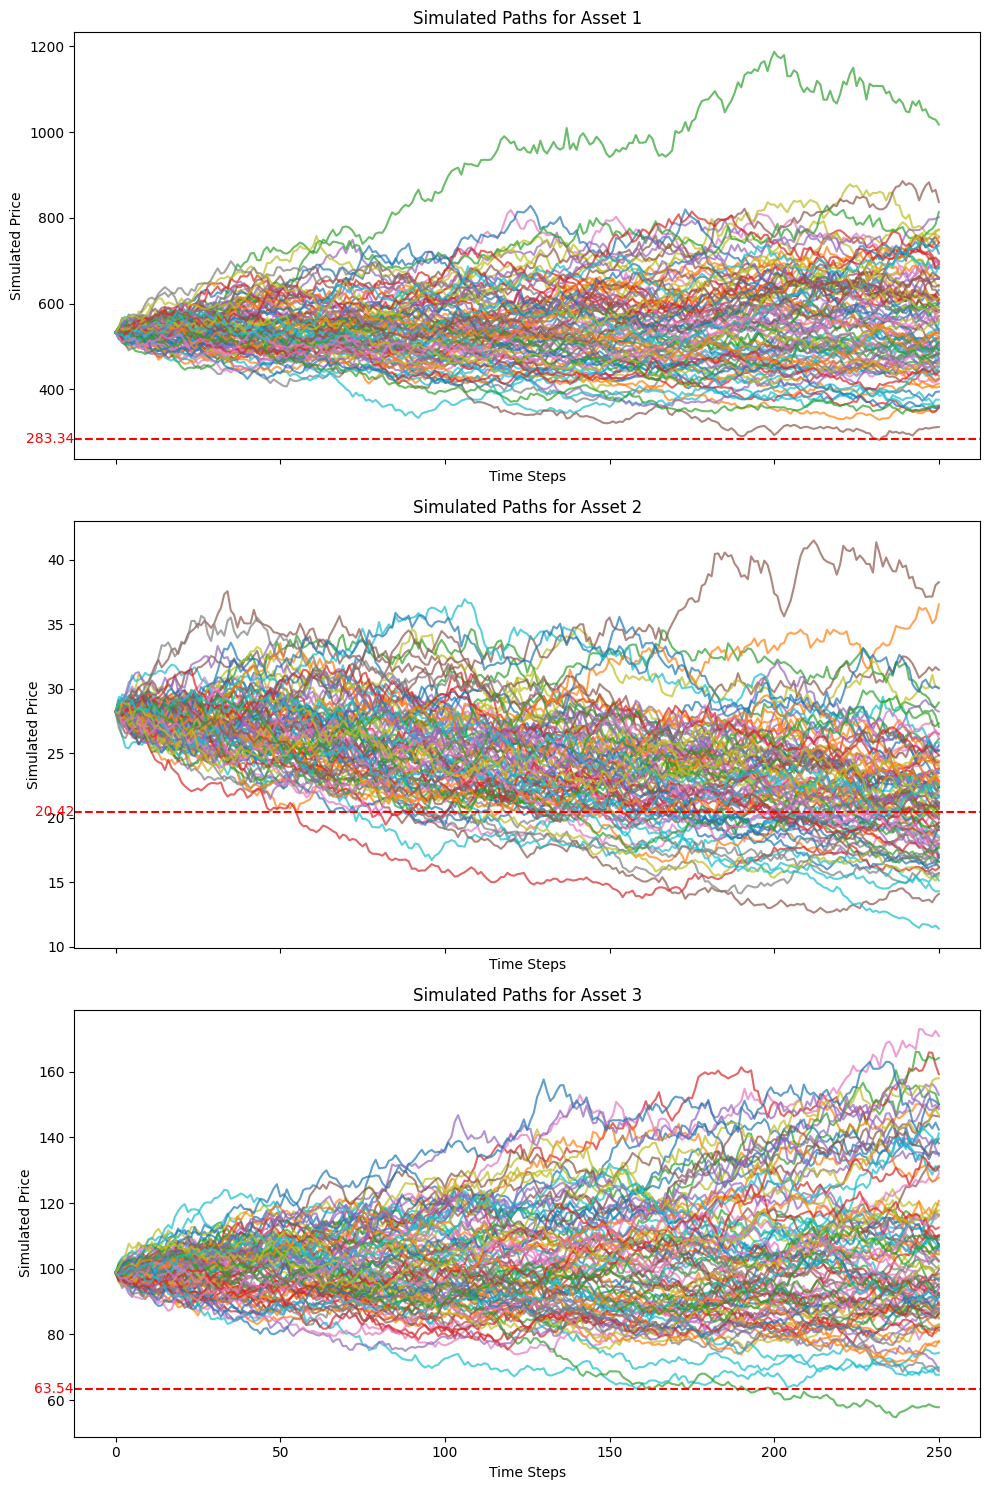

In [2]:
from GBM import MultiBS
import numpy as np

path1 = "datasets/UNH.csv"
path2 = "datasets/PFE.csv"
path3 = "datasets/MRK.csv"

multi_bs = MultiBS()

forward_simulation = multi_bs.simulate_multi_GBM_exact(T=1, M=10_000)
v, sigma = multi_bs.calibrate_model(forward_simulation)
simul = multi_bs.simulate_multi_GBM_exact(T=1, M=100)
multi_bs.plot(simul)

In [3]:
import pandas as pd
start_date="2023-08-23"

start_date = pd.to_datetime(start_date).strftime("%Y-%m-%d")
# Find the index of the start_date in the asset data
start_index = multi_bs.asset_1.loc[multi_bs.asset_1["Date"] == start_date]["Close"].index[0]

# Slice the historical data from start_date onwards
historical_prices_1 = multi_bs.asset_1["Close"].iloc[start_index:].values
historical_prices_2 = multi_bs.asset_2["Close"].iloc[start_index:].values
historical_prices_3 = multi_bs.asset_3["Close"].iloc[start_index:].values
historical_prices = np.column_stack([historical_prices_1, historical_prices_2, historical_prices_3])
historical_prices[0, :]

array([480.22924805,  34.61804962, 107.69082642])

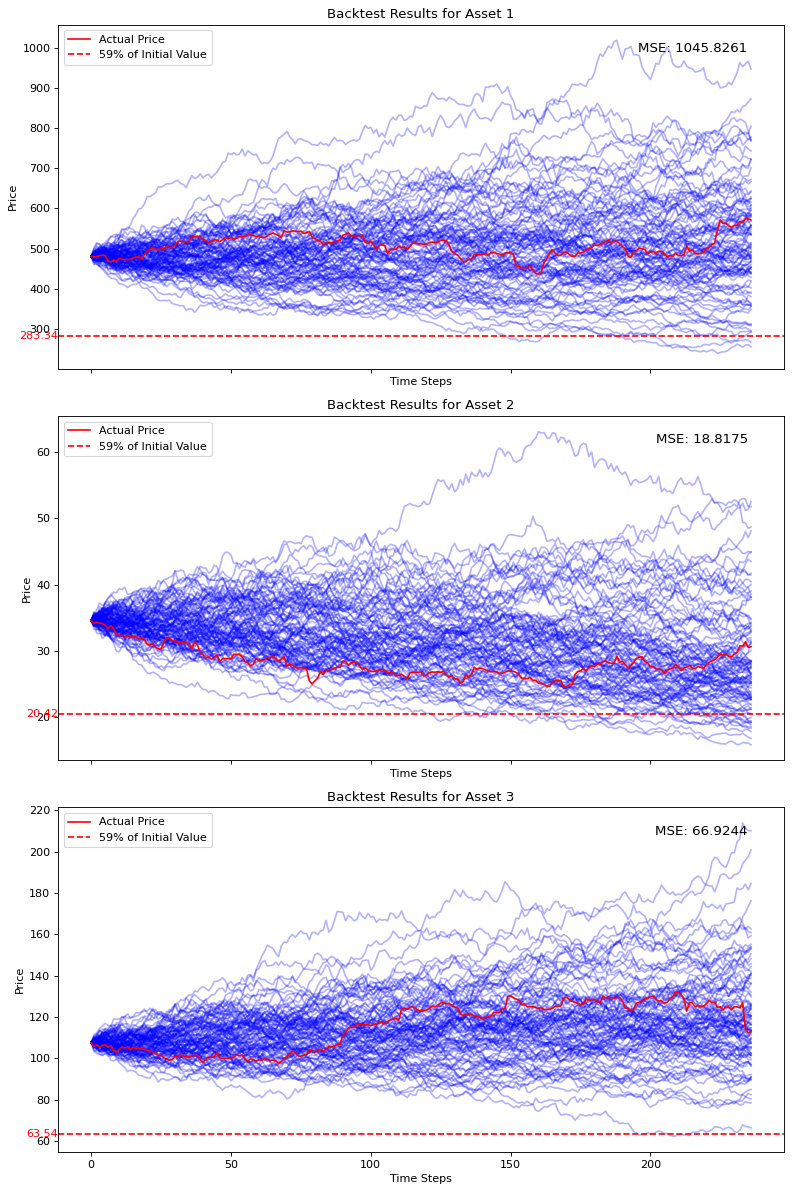

Mean Squared Error (MSE) for each asset: [1045.82608253   18.81746428   66.92438575]
Root Mean Squared Error (RMSE) for each asset: [32.33923441  4.33791013  8.18073259]


array([1045.82608253,   18.81746428,   66.92438575])

In [4]:
multi_bs.backtest(M=100)

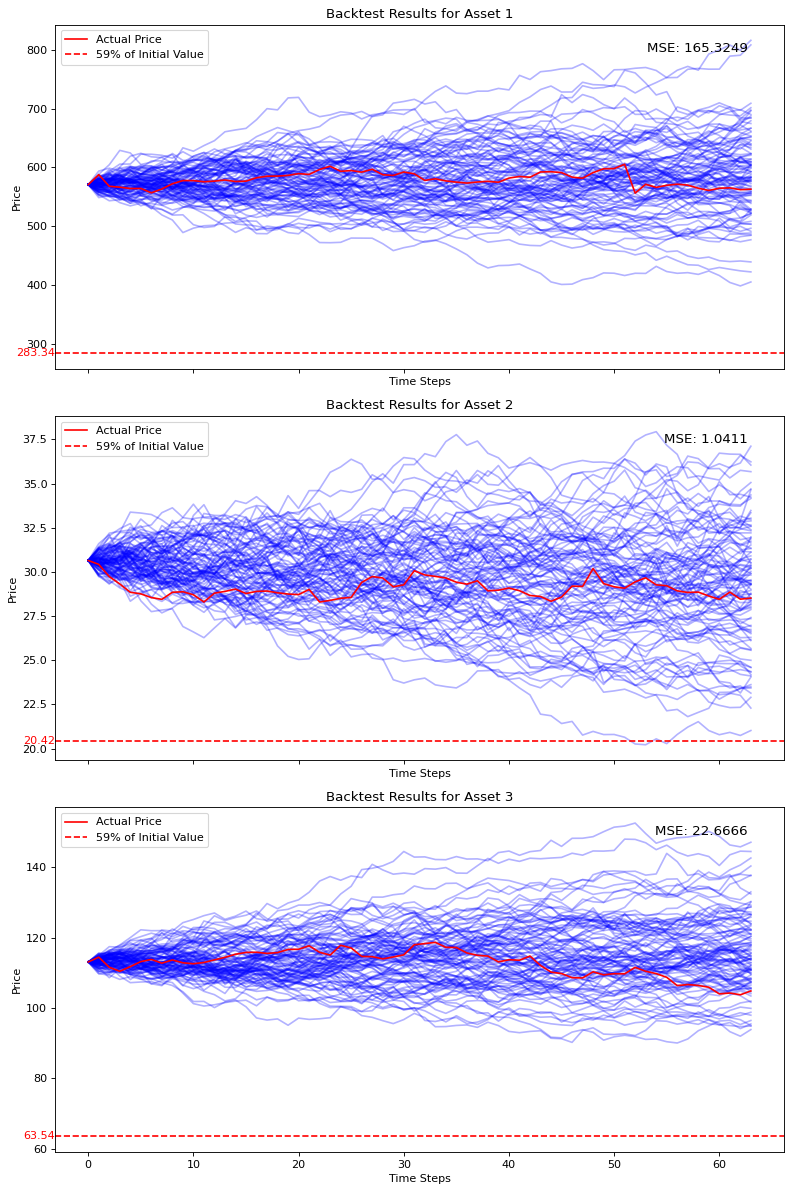

Mean Squared Error (MSE) for each asset: [165.32491719   1.04113714  22.66661236]
Root Mean Squared Error (RMSE) for each asset: [12.85787374  1.02036128  4.76094658]


array([165.32491719,   1.04113714,  22.66661236])

In [5]:
multi_bs.backtest(M=100, start_date="2024-08-01", end_date="2024-10-30")

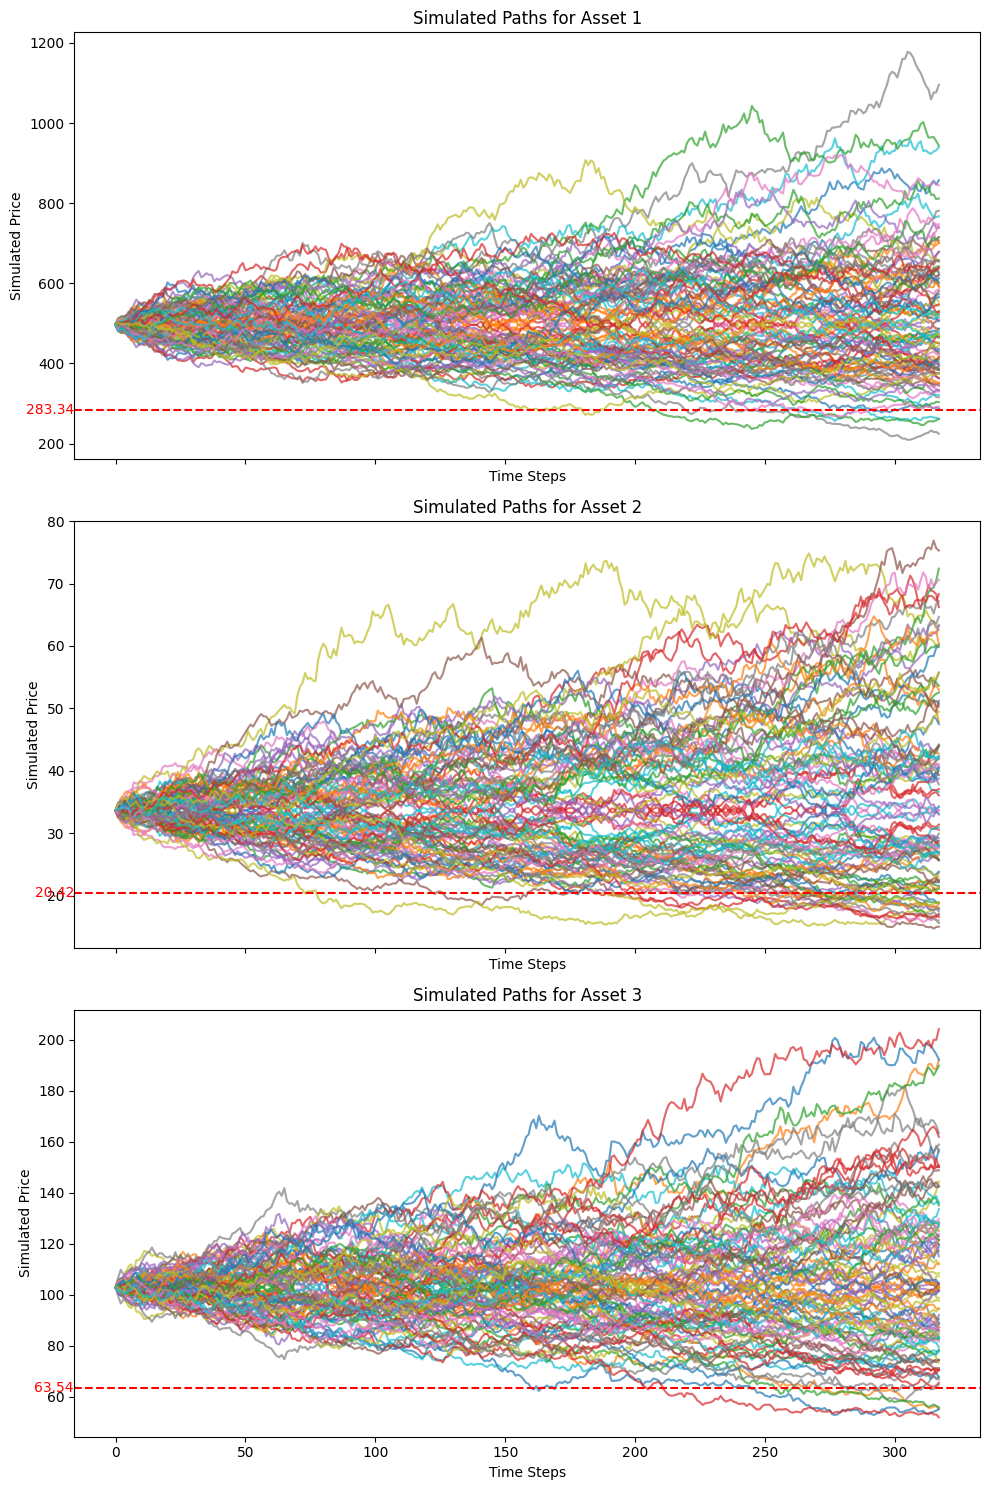

In [6]:
simul = multi_bs.simulate_multi_GBM_antithetic(T=317/250, M=100)
multi_bs.plot(simul)

In [7]:
start_date="2023-08-23"
start_date = pd.to_datetime(start_date).strftime("%Y-%m-%d")
# Find the index of the start_date in the asset data
start_index = multi_bs.asset_1.loc[multi_bs.asset_1["Date"] == start_date]["Close"].index[0]

historical_prices_1 = multi_bs.asset_1["Close"].iloc[start_index]
historical_prices_2 = multi_bs.asset_2["Close"].iloc[start_index]
historical_prices_3 = multi_bs.asset_3["Close"].iloc[start_index]
S0 = np.array([historical_prices_1, historical_prices_2, historical_prices_3])
print(S0)

[480.22924805  34.61804962 107.69082642]


In [ ]:
from payoff import CallablePayoff
from tqdm import tqdm

payoff = CallablePayoff(0, r=0.0419, S0=S0)


epochs = 100
with tqdm(total=epochs, desc="Training Progress") as pbar:
    for epoch in range(epochs):
        path = multi_bs.simulate_multi_GBM_exact(T=317/multi_bs.dt, M=1_000,S0=S0) # 317 business days from initial fixing to final fixing
        path = np.log(path) # in asset, timestep, path
        # (path #, asset #, timestep #)
        path = path.transpose(2, 0, 1)
        losses = payoff.minimise_over_path(path)
        pbar.set_postfix({'Worst loss': max(losses), 
                            'Best Loss': min(losses)})
        pbar.update(1)

path = multi_bs.simulate_multi_GBM_exact(T=317/multi_bs.dt, M=10_000,S0=S0)

x = payoff.evaluate_payoff(path[:,:,:,0], True)
print(x)

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
delta = multi_bs.calculate_delta(T=1.5, h=0.01)
gamma = multi_bs.calculate_gamma(T=1.5, h=0.01)

In [22]:
print(multi_bs.v, multi_bs.Sigma)

[-0.02757865 -0.02908197 -0.0197659 ] tensor([[0.0554, 0.0170, 0.0126],
        [0.0170, 0.0584, 0.0158],
        [0.0126, 0.0158, 0.0397]])


In [23]:
print(f"Delta: {delta}, \nGamma: \n{gamma}")

Delta: [-0.05077797 -0.18734916 -0.01286955], 
Gamma: 
[[ 0.00594985  0.17444509  0.04106891]
 [ 0.00703164 -0.14019132  0.0363978 ]
 [-0.00294624 -0.23202048 -0.01449255]]


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Generate log-spaced values for h between 0.001 and 0.05
h_values = np.logspace(-3, -1, num=1000)  # 5 values from 0.001 to approximately 0.05
T = 1.5
M = 1000
deltas = []
gammas = []

# Calculate Delta and Gamma for each h value
for h in h_values:
    delta = multi_bs.calculate_delta(T, M, h)
    gamma = multi_bs.calculate_gamma(T, M, h)
    deltas.append(delta)
    gammas.append(gamma)

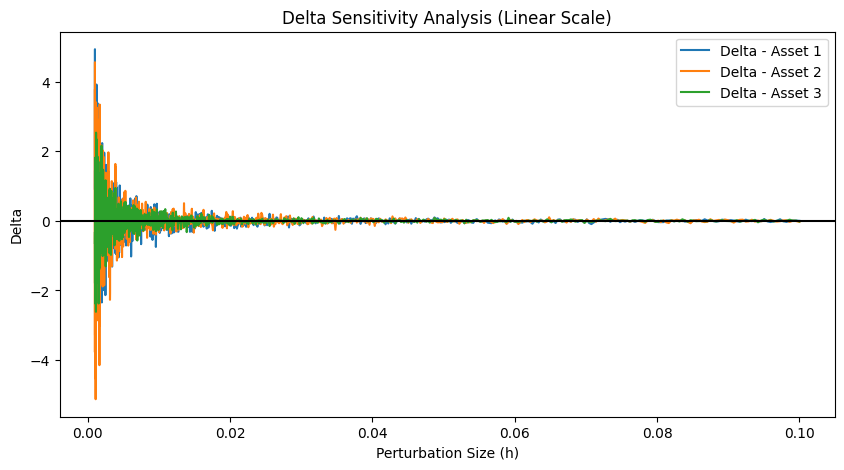

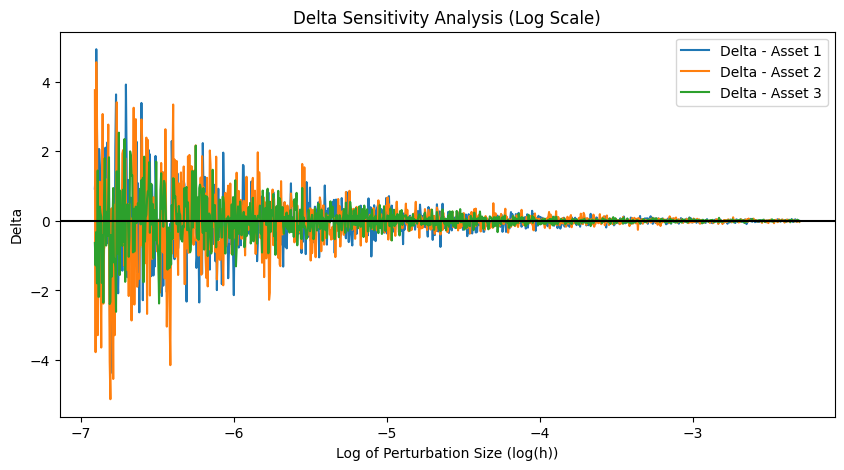

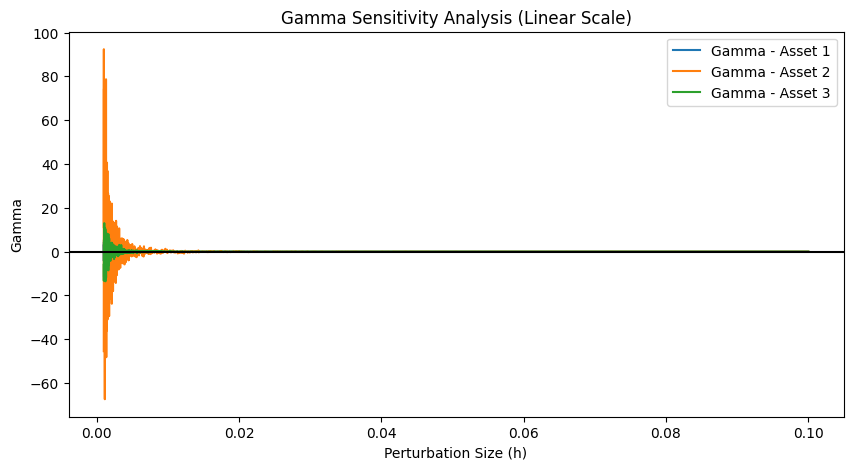

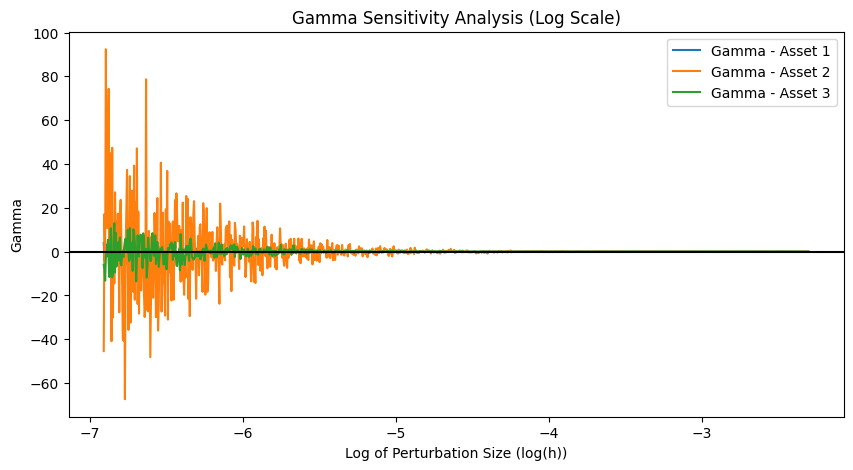

In [20]:
# Plot Delta in h scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(h_values, [d[i] for d in deltas], label=f"Delta - Asset {i+1}")
plt.axhline(0, color="black")

plt.xlabel("Perturbation Size (h)")
plt.ylabel("Delta")
plt.title("Delta Sensitivity Analysis (Linear Scale)")
plt.xscale("linear")
plt.legend()
plt.show()

# Plot Delta in log(h) scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(np.log(h_values), [d[i] for d in deltas], label=f"Delta - Asset {i+1}")
plt.axhline(0, color="black")
plt.xlabel("Log of Perturbation Size (log(h))")
plt.ylabel("Delta")
plt.title("Delta Sensitivity Analysis (Log Scale)")
plt.xscale("linear")
plt.legend()
plt.show()

# Plot Gamma (diagonal terms) in h scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(h_values, [g[i, i] for g in gammas], label=f"Gamma - Asset {i+1}")
plt.axhline(0, color="black")
plt.xlabel("Perturbation Size (h)")
plt.ylabel("Gamma")
plt.title("Gamma Sensitivity Analysis (Linear Scale)")
plt.xscale("linear")
plt.legend()
plt.show()

# Plot Gamma (diagonal terms) in log(h) scale
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(np.log(h_values), [g[i, i] for g in gammas], label=f"Gamma - Asset {i+1}")
plt.axhline(0, color="black")
plt.xlabel("Log of Perturbation Size (log(h))")
plt.ylabel("Gamma")
plt.title("Gamma Sensitivity Analysis (Log Scale)")
plt.xscale("linear")
plt.legend()
plt.show()